In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

from callbacks import all_callbacks

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning, prune_low_magnitude
tf.get_logger().setLevel('ERROR')


### Import the MNIST data class and call it.

Original dataset and modified dataset with modifiable resolution is shown below.

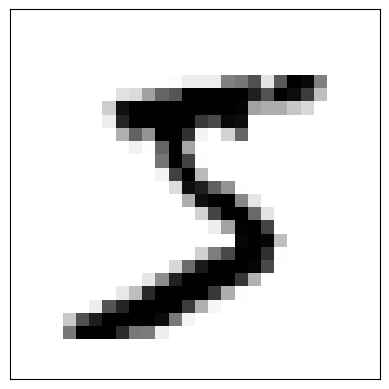

In [2]:
import MNIST_database as mnist
size_final = 28

data = mnist.MNISTData(size_initial=28, size_final=size_final, color_depth=8)
train= data.x_train
ax = plt.subplot(1, 1 , 1)

plt.imshow(train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


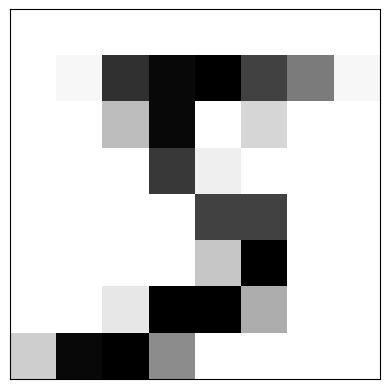

In [3]:
import MNIST_database as mnist

#Choose the final size of your image dataset
size_final = 8

data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
train= data_zoom.x_train
ax = plt.subplot(1, 1 , 1)

plt.imshow(train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Autoencoder using Keras
The aim of this class is to implement a simple autoencoder for the MNIST data and then build an autoencoder that is
able to classify MNIST data in its latent dimension.

Code partially adapted from [Keras Documentation](https://blog.keras.io/building-autoencoders-in-keras.html).

In [4]:
class Autoencoder:
    """Autoencoder Class"""

    def __init__(self, data: mnist.MNISTData, num_classes=10, pruned = False):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.pruned = pruned
        self.input_shape = (self.x_train.shape[-1],)
        self.input = Input(shape=self.input_shape, name='encoder_input')
        self.latent_dim = 2

        self.encoder = None
        self.encoder_model = None
        self.decoder = None
        self.decoder_model = None
        self.latent_classifier = None
        self.classifier = None
        self.autoencoder = None

        self.history = None

        self.pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.85, begin_step=2000, end_step=10000, frequency=100)}
    
    def build_encoder(self):
        """Build your encoder architecture and store the output in self.encoder. 
        The final encoding dimension is 2."""

        self.encoder = Dense(15, name='fc1', activation='relu')(self.input)
        if self.pruned:
            self.encoder = prune_low_magnitude(Dense(15, name='fc2_prun',  activation='relu'), **self.pruning_params)(self.encoder) 
            self.encoder = prune_low_magnitude(Dense(15, name='fc2.1_prun',  activation='relu'), **self.pruning_params)(self.encoder) 

        
        if not self.pruned:
            self.encoder = Dense(15, name='fc2',  activation='relu')(self.encoder)
            self.encoder = Dense(15, name='fc2.1',  activation='relu')(self.encoder)   
   

        self.encoder = Dense(self.latent_dim,  activation='relu', name = 'encoder_output')(self.encoder)
        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = tf.keras.Model(self.input, self.encoder, name='encoder')

    def build_decoder(self):
        """Build the decoder architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the decoder!")

        if self.pruned:
            self.decoder = prune_low_magnitude(Dense(16,  name='fc3_pruned', activation='relu'), **self.pruning_params)(self.encoder)
        
        if not self.pruned:
            self.decoder = Dense(16, name='fc3', activation='relu')(self.encoder)
        self.decoder = Dense(32, name='fc4', activation='relu')(self.decoder)     
        self.decoder = Dense(32, name='fc4.1', activation='relu')(self.decoder)     

        
        self.decoder = Dense(self.input_shape[0],activation='sigmoid', name='ecoder_output')(self.decoder)
        
    def build_classifier(self):
        """ Building the classifier architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the classifier!")
        
        if self.pruned:
            self.latent_classifier = prune_low_magnitude(Dense(16, name='fc3_prunclass', activation='relu'), **self.pruning_params)(self.encoder)

        if not self.pruned:
            self.latent_classifier = Dense(16, name='fc3_class', activation='relu')(self.encoder)
        
        self.latent_classifier = Dense(40, name='fc4_class', activation='relu')(self.latent_classifier)
        self.latent_classifier = Dense(self.num_classes, activation='softmax', name='classifier_output')(self.latent_classifier)
    def build_autoencoder(self, use_latent_classifier=False):
        """ Build the whole autoencoder Model from self.encoder and self.decoder."""
        self.dir()
        
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")
        
        if use_latent_classifier:
            if self.latent_classifier is None:
                raise RuntimeError("If you want to use the option with the latent classifier, you have to build it "
                                   "beforehand!")
            self.autoencoder = tf.keras.Model(self.input, outputs=[self.decoder, self.latent_classifier])
            self.autoencoder.compile(loss=['mse', 'categorical_crossentropy'], loss_weights=[1, 0.1], optimizer='adam',
                                     metrics="accuracy")
            if not self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_model_w_classifier.h5')
            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_model_w_classifier.h5')
    
        else:
            self.autoencoder = tf.keras.Model(self.input, outputs=self.decoder, name = 'autoencoder')
            self.autoencoder.compile(loss='mse', optimizer='adam') 
            if not self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_model_wo_classifier.h5')
            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_model_wo_classifier.h5')
        self.autoencoder.summary()
        
    def fit_data(self, batch_size=256, epochs=30, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""
        
        callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model/AE_model/model_2')
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep()) 
        
        if use_latent_classifier:
            self.history = self.autoencoder.fit(self.x_train, [self.x_train, self.y_train],
                                                validation_data=(self.x_test, [self.x_test, self.y_test]),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True, callbacks=callbacks.callbacks)
            self.autoencoder = strip_pruning(self.autoencoder)
            if not self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_best_model_classifier.h5')
            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_best_model_classifier.h5')
        else:                         
            self.history = self.autoencoder.fit(self.x_train, self.x_train,
                                                validation_data=(self.x_test, self.x_test),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True, callbacks=callbacks.callbacks)  
            self.autoencoder = strip_pruning(self.autoencoder)
            if not self.pruned:
                # self.autoencoder.save('model/AE_model/KERAS_check_best_model.h5')
                self.autoencoder.save('model/AE_model/KERAS_check_best_model.model')

            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_best_model.h5')

        self.history = self.history.history

    def dir(self):
        """Creation of the folders path to store the results."""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/AE")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
        dir3 = os.path.join("model")
        if not os.path.exists(dir3):
            os.mkdir(dir3)
        dir4 = os.path.join("./model/AE_model")
        if not os.path.exists(dir4):
            os.mkdir(dir4)
        
    
    def plot_score(self, use_latent_classifier = False, model_name=None):
        """Plots the scores achieved during the fitting."""
        if use_latent_classifier is False:
            plt.plot(self.history['loss'])
            plt.plot(self.history['val_loss'])
            plt.ylabel('Model Accuracy')
        else:
            plt.plot(self.history['classifier_output_accuracy'])
            plt.plot(self.history['val_classifier_output_accuracy'])
            plt.ylabel('Classifier Accuracy')
        
        plt.xlabel('Epoch')        
        plt.legend(['Train', 'Test'], loc='best')
        plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/AE/Accuracy of {model_name}.png'.format(model_name=model_name))
        
        plt.show()

    def plot_latent_dimension(self, model_name = None):
        """Plots the latent dimension of the autoencoder."""
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[:, 0], prediction[:, 1], c=np.argmax(self.y_test, axis=1), cmap="Set3")
        plt.colorbar()
        plt.title('Latent space {model_name}'.format(model_name=model_name))


        plt.savefig('./images/AE/Latent dimension of {model_name}.png'.format(model_name=model_name))

        plt.show()

    def plot_reco(self, use_latent_classifier = False, model_name = None):
        """Plotting reconstructed images"""
        
        n = 6
        plt.figure(figsize=(10, 3))
        reco_imgs = self.autoencoder.predict(self.x_test)
        img_size = int(np.sqrt(self.input_shape[0]))

        
        if use_latent_classifier :
            raise RuntimeError("You are considering the autoencoder with classifier!")
        else:
        
            for i in range(n):
                # Display original MNIST
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(self.x_test[i].reshape(img_size,img_size), cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # Display reconstructed MNIST            
                ax = plt.subplot(2, n, i + n + 1)
                plt.imshow(reco_imgs[i].reshape(img_size,img_size), cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
            plt.savefig('./images/AE/reconstructed images{model_name}.png'.format(model_name=model_name))
            plt.show()
            
    def plot_latent(self):
        n = 6
        plt.figure(figsize=(10, 3))
        reco_imgs = self.encoder_model.predict(self.x_test)
        img_size = int(np.sqrt(self.input_shape[0]))

        ax = plt.subplot(1, 1, 1)
        plt.imshow(reco_imgs[1].reshape(2,1), cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.show()


It is built the standard autoencoder, *without classifier* here, and the MNIST data class called before is used. 
The model is fitted and adequate plots are reproduced, 
as well as the comparison between orginal MNIST dataset and reconstructed images.

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64)]              0         
                                                                 
 fc1 (Dense)                 (None, 15)                975       
                                                                 
 fc2 (Dense)                 (None, 15)                240       
                                                                 
 fc2.1 (Dense)               (None, 15)                240       
                                                                 
 encoder_output (Dense)      (None, 2)                 32        
                                                                 
 fc3 (Dense)                 (None, 16)                48        
                                                                 
 fc4 (Dense)                 (None, 32)                


Epoch 1: val_loss improved from inf to 0.09209, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 14ms/step - loss: 0.1199 - val_loss: 0.0921 - lr: 0.0010
Epoch 2/30
224/235 [===========================>..] - ETA: 0s - loss: 0.0892
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 2: val_loss improved from 0.09209 to 0.08768, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 2: val_loss improved from 0.09209 to 0.08768, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 13ms/step - loss: 0.0891 - val_loss: 0.0877 - lr: 0.0010
Epoch 3/30
233/235 [============================>.] - ETA: 0s - loss: 0.0866
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 3: val_loss improved from 0.08768 to 0.08508, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 3: val_loss improved from 0.08768 to 0.08508, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0866 - val_loss: 0.0851 - lr: 0.0010
Epoch 4/30
225/235 [===========================>..] - ETA: 0s - loss: 0.0808
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 4: val_loss improved from 0.08508 to 0.07724, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 4: val_loss improved from 0.08508 to 0.07724, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 11ms/step - loss: 0.0807 - val_loss: 0.0772 - lr: 0.0010
Epoch 5/30
235/235 [==============================] - ETA: 0s - loss: 0.0762
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 5: val_loss improved from 0.07724 to 0.07462, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 5: val_loss improved from 0.07724 to 0.07462, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 11ms/step - loss: 0.0762 - val_loss: 0.0746 - lr: 0.0010
Epoch 6/30
227/235 [===========================>..] - ETA: 0s - loss: 0.0740
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 6: val_loss improved from 0.07462 to 0.07280, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 6: val_loss improved from 0.07462 to 0.07280, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 13ms/step - loss: 0.0740 - val_loss: 0.0728 - lr: 0.0010
Epoch 7/30
227/235 [===========================>..] - ETA: 0s - loss: 0.0725
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 7: val_loss improved from 0.07280 to 0.07149, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 7: val_loss improved from 0.07280 to 0.07149, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0724 - val_loss: 0.0715 - lr: 0.0010
Epoch 8/30
224/235 [===========================>..] - ETA: 0s - loss: 0.0714
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 8: val_loss improved from 0.07149 to 0.07054, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 8: val_loss improved from 0.07149 to 0.07054, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 14ms/step - loss: 0.0714 - val_loss: 0.0705 - lr: 0.0010
Epoch 9/30
234/235 [============================>.] - ETA: 0s - loss: 0.0706
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 9: val_loss improved from 0.07054 to 0.06990, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 9: val_loss improved from 0.07054 to 0.06990, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 9: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 9: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0706 - val_loss: 0.0699 - lr: 0.0010
Epoch 10/30
234/235 [============================>.] - ETA: 0s - loss: 0.0700
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 10: val_loss improved from 0.06990 to 0.06944, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 10: val_loss improved from 0.06990 to 0.06944, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 10: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 10: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 10: saving model to model/AE_model/model_2\KERAS_check_model_epoch10.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0700 - val_loss: 0.0694 - lr: 0.0010
Epoch 11/30
229/235 [============================>.] - ETA: 0s - loss: 0.0694
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 11: val_loss improved from 0.06944 to 0.06879, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 11: val_loss improved from 0.06944 to 0.06879, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 11: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 11: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 11ms/step - loss: 0.0694 - val_loss: 0.0688 - lr: 0.0010
Epoch 12/30
230/235 [============================>.] - ETA: 0s - loss: 0.0687
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 12: val_loss improved from 0.06879 to 0.06810, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 12: val_loss improved from 0.06879 to 0.06810, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 12: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 12: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 11ms/step - loss: 0.0687 - val_loss: 0.0681 - lr: 0.0010
Epoch 13/30
225/235 [===========================>..] - ETA: 0s - loss: 0.0680
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 13: val_loss improved from 0.06810 to 0.06760, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 13: val_loss improved from 0.06810 to 0.06760, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 13: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 13: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 11ms/step - loss: 0.0681 - val_loss: 0.0676 - lr: 0.0010
Epoch 14/30
224/235 [===========================>..] - ETA: 0s - loss: 0.0675
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 14: val_loss improved from 0.06760 to 0.06710, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 14: val_loss improved from 0.06760 to 0.06710, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 14: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 14: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 14ms/step - loss: 0.0675 - val_loss: 0.0671 - lr: 0.0010
Epoch 15/30
227/235 [===========================>..] - ETA: 0s - loss: 0.0670
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 15: val_loss improved from 0.06710 to 0.06682, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 15: val_loss improved from 0.06710 to 0.06682, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 15: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 15: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0670 - val_loss: 0.0668 - lr: 0.0010
Epoch 16/30
221/235 [===========================>..] - ETA: 0s - loss: 0.0666
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 16: val_loss improved from 0.06682 to 0.06615, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 16: val_loss improved from 0.06682 to 0.06615, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 16: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 16: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0666 - val_loss: 0.0661 - lr: 0.0010
Epoch 17/30
225/235 [===========================>..] - ETA: 0s - loss: 0.0662
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 17: val_loss improved from 0.06615 to 0.06582, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 17: val_loss improved from 0.06615 to 0.06582, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 17: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 17: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0661 - val_loss: 0.0658 - lr: 0.0010
Epoch 18/30
221/235 [===========================>..] - ETA: 0s - loss: 0.0657
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 18: val_loss improved from 0.06582 to 0.06549, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 18: val_loss improved from 0.06582 to 0.06549, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 15ms/step - loss: 0.0657 - val_loss: 0.0655 - lr: 0.0010
Epoch 19/30
221/235 [===========================>..] - ETA: 0s - loss: 0.0653
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 19: val_loss improved from 0.06549 to 0.06505, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 19: val_loss improved from 0.06549 to 0.06505, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0653 - val_loss: 0.0651 - lr: 0.0010
Epoch 20/30
222/235 [===========================>..] - ETA: 0s - loss: 0.0649
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 20: val_loss improved from 0.06505 to 0.06475, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 20: val_loss improved from 0.06505 to 0.06475, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_epoch20.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0649 - val_loss: 0.0647 - lr: 0.0010
Epoch 21/30
224/235 [===========================>..] - ETA: 0s - loss: 0.0646
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 21: val_loss improved from 0.06475 to 0.06454, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 21: val_loss improved from 0.06475 to 0.06454, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 14ms/step - loss: 0.0645 - val_loss: 0.0645 - lr: 0.0010
Epoch 22/30
227/235 [===========================>..] - ETA: 0s - loss: 0.0643
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 22: val_loss improved from 0.06454 to 0.06419, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 22: val_loss improved from 0.06454 to 0.06419, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 18ms/step - loss: 0.0642 - val_loss: 0.0642 - lr: 0.0010
Epoch 23/30
224/235 [===========================>..] - ETA: 0s - loss: 0.0640
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 23: val_loss improved from 0.06419 to 0.06396, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 23: val_loss improved from 0.06419 to 0.06396, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 13ms/step - loss: 0.0639 - val_loss: 0.0640 - lr: 0.0010
Epoch 24/30
235/235 [==============================] - ETA: 0s - loss: 0.0637
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 24: val_loss improved from 0.06396 to 0.06381, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 24: val_loss improved from 0.06396 to 0.06381, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0637 - val_loss: 0.0638 - lr: 0.0010
Epoch 25/30
229/235 [============================>.] - ETA: 0s - loss: 0.0635
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 25: val_loss improved from 0.06381 to 0.06346, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 25: val_loss improved from 0.06381 to 0.06346, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 16ms/step - loss: 0.0635 - val_loss: 0.0635 - lr: 0.0010
Epoch 26/30
234/235 [============================>.] - ETA: 0s - loss: 0.0632
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 26: val_loss improved from 0.06346 to 0.06321, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 26: val_loss improved from 0.06346 to 0.06321, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 14ms/step - loss: 0.0632 - val_loss: 0.0632 - lr: 0.0010
Epoch 27/30
233/235 [============================>.] - ETA: 0s - loss: 0.0630
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 27: val_loss improved from 0.06321 to 0.06313, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 27: val_loss improved from 0.06321 to 0.06313, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 27: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 27: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 15ms/step - loss: 0.0630 - val_loss: 0.0631 - lr: 0.0010
Epoch 28/30
223/235 [===========================>..] - ETA: 0s - loss: 0.0628
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 28: val_loss improved from 0.06313 to 0.06306, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 28: val_loss improved from 0.06313 to 0.06306, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 28: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 28: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 12ms/step - loss: 0.0628 - val_loss: 0.0631 - lr: 0.0010
Epoch 29/30
227/235 [===========================>..] - ETA: 0s - loss: 0.0627
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 29: val_loss improved from 0.06306 to 0.06277, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 29: val_loss improved from 0.06306 to 0.06277, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 3s 15ms/step - loss: 0.0627 - val_loss: 0.0628 - lr: 0.0010
Epoch 30/30
226/235 [===========================>..] - ETA: 0s - loss: 0.0625
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 30: val_loss improved from 0.06277 to 0.06255, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 30: val_loss improved from 0.06277 to 0.06255, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 30: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 30: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 30: saving model to model/AE_model/model_2\KERAS_check_model_epoch30.h5

***callbacks end***

313/313 [==============================] - 1s 1ms/step


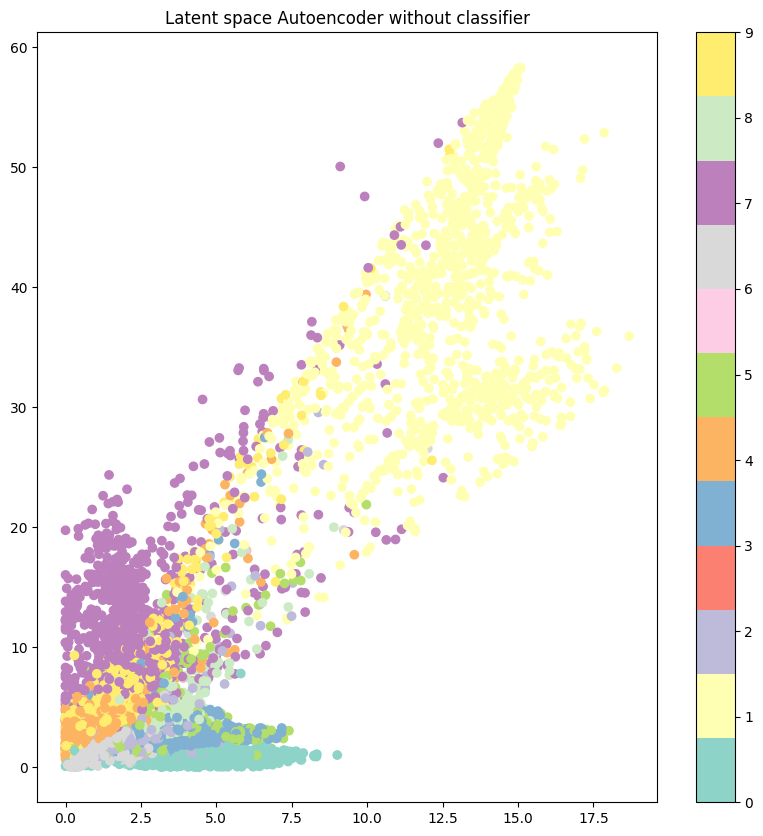

313/313 [==============================] - 1s 2ms/step


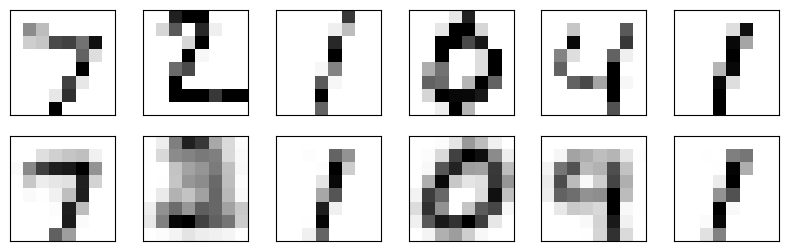

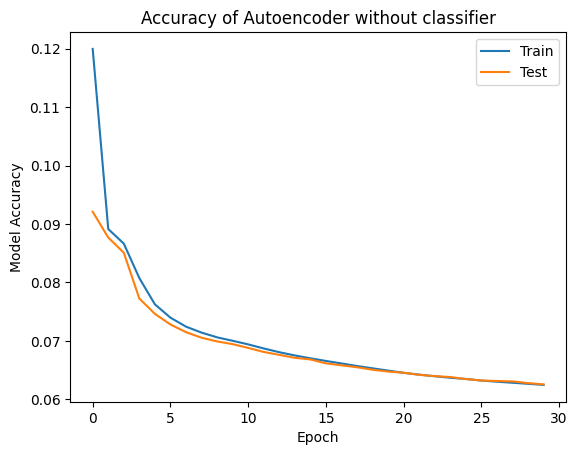

313/313 [==============================] - 1s 2ms/step


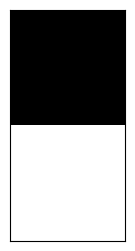

In [5]:
network = Autoencoder(data_zoom, pruned=False)
network.build_encoder()
network.build_decoder()
network.build_autoencoder()
network.fit_data(epochs=30)
network.plot_latent_dimension("Autoencoder without classifier")
network.plot_reco(model_name="complete")
network.plot_score(use_latent_classifier=False, model_name="Autoencoder without classifier")
network.plot_latent()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64)]              0         
                                                                 
 fc1 (Dense)                 (None, 15)                975       
                                                                 
 prune_low_magnitude_fc2_pru  (None, 15)               467       
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_fc2.1_p  (None, 15)               467       
 run (PruneLowMagnitude)                                         
                                                                 
 encoder_output (Dense)      (None, 2)                 32        
                                                                 
 prune_low_magnitude_fc3_pru  (None, 16)               


Epoch 1: val_loss improved from inf to 0.09411, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 11s 24ms/step - loss: 0.1162 - val_loss: 0.0941 - lr: 0.0010
Epoch 2/30
232/235 [============================>.] - ETA: 0s - loss: 0.0918
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 2: val_loss improved from 0.09411 to 0.09005, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 2: val_loss improved from 0.09411 to 0.09005, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 28ms/step - loss: 0.0918 - val_loss: 0.0901 - lr: 0.0010
Epoch 3/30
234/235 [============================>.] - ETA: 0s - loss: 0.0888
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 3: val_loss improved from 0.09005 to 0.08741, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 3: val_loss improved from 0.09005 to 0.08741, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.0888 - val_loss: 0.0874 - lr: 0.0010
Epoch 4/30
223/235 [===========================>..] - ETA: 0s - loss: 0.0859
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 4: val_loss improved from 0.08741 to 0.08495, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 4: val_loss improved from 0.08741 to 0.08495, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 34ms/step - loss: 0.0859 - val_loss: 0.0849 - lr: 0.0010
Epoch 5/30
230/235 [============================>.] - ETA: 0s - loss: 0.0818
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 5: val_loss improved from 0.08495 to 0.07834, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 5: val_loss improved from 0.08495 to 0.07834, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 22ms/step - loss: 0.0818 - val_loss: 0.0783 - lr: 0.0010
Epoch 6/30
228/235 [============================>.] - ETA: 0s - loss: 0.0767
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 6: val_loss improved from 0.07834 to 0.07401, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 6: val_loss improved from 0.07834 to 0.07401, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.0767 - val_loss: 0.0740 - lr: 0.0010
Epoch 7/30
235/235 [==============================] - ETA: 0s - loss: 0.0730
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 7: val_loss improved from 0.07401 to 0.07134, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 7: val_loss improved from 0.07401 to 0.07134, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 23ms/step - loss: 0.0730 - val_loss: 0.0713 - lr: 0.0010
Epoch 8/30
234/235 [============================>.] - ETA: 0s - loss: 0.0709
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 8: val_loss improved from 0.07134 to 0.06991, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 8: val_loss improved from 0.07134 to 0.06991, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 36ms/step - loss: 0.0709 - val_loss: 0.0699 - lr: 0.0010
Epoch 9/30
234/235 [============================>.] - ETA: 0s - loss: 0.0790
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 9: val_loss did not improve from 0.06991

Epoch 9: val_loss did not improve from 0.06991

Epoch 9: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 9: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 1s 6ms/step - loss: 0.0790 - val_loss: 0.0782 - lr: 0.0010
Epoch 10/30
226/235 [===========================>..] - ETA: 0s - loss


Epoch 15: val_loss improved from 0.06991 to 0.06973, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 15: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 15: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 22ms/step - loss: 0.0702 - val_loss: 0.0697 - lr: 0.0010
Epoch 16/30
231/235 [============================>.] - ETA: 0s - loss: 0.0698
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 16: val_loss improved from 0.06973 to 0.06929, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 16: val_loss improved from 0.06973 to 0.06929, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 16: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 16: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 21ms/step - loss: 0.0698 - val_loss: 0.0693 - lr: 0.0010
Epoch 17/30
234/235 [============================>.] - ETA: 0s - loss: 0.0694
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 17: val_loss improved from 0.06929 to 0.06903, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 17: val_loss improved from 0.06929 to 0.06903, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 17: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 17: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 22ms/step - loss: 0.0694 - val_loss: 0.0690 - lr: 0.0010
Epoch 18/30
229/235 [============================>.] - ETA: 0s - loss: 0.0691
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 18: val_loss improved from 0.06903 to 0.06882, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 18: val_loss improved from 0.06903 to 0.06882, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 26ms/step - loss: 0.0691 - val_loss: 0.0688 - lr: 0.0010
Epoch 19/30
226/235 [===========================>..] - ETA: 0s - loss: 0.0688
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 19: val_loss improved from 0.06882 to 0.06848, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 19: val_loss improved from 0.06882 to 0.06848, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 23ms/step - loss: 0.0688 - val_loss: 0.0685 - lr: 0.0010
Epoch 20/30
232/235 [============================>.] - ETA: 0s - loss: 0.0686
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 20: val_loss improved from 0.06848 to 0.06830, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 20: val_loss improved from 0.06848 to 0.06830, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_epoch20.h5

***callbacks end***

235/235 [==============================] - 8s 36ms/step - loss: 0.0686 - val_loss: 0.0683 - lr: 0.0010
Epoch 21/30
225/235 [===========================>..] - ETA: 0s - loss: 0.0683
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 21: val_loss improved from 0.06830 to 0.06817, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 21: val_loss improved from 0.06830 to 0.06817, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 26ms/step - loss: 0.0683 - val_loss: 0.0682 - lr: 0.0010
Epoch 22/30
232/235 [============================>.] - ETA: 0s - loss: 0.0681
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 22: val_loss improved from 0.06817 to 0.06799, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 22: val_loss improved from 0.06817 to 0.06799, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.0681 - val_loss: 0.0680 - lr: 0.0010
Epoch 23/30
225/235 [===========================>..] - ETA: 0s - loss: 0.0680
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 23: val_loss improved from 0.06799 to 0.06765, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 23: val_loss improved from 0.06799 to 0.06765, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 23ms/step - loss: 0.0679 - val_loss: 0.0677 - lr: 0.0010
Epoch 24/30
234/235 [============================>.] - ETA: 0s - loss: 0.0678
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 24: val_loss improved from 0.06765 to 0.06749, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 24: val_loss improved from 0.06765 to 0.06749, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 22ms/step - loss: 0.0678 - val_loss: 0.0675 - lr: 0.0010
Epoch 25/30
229/235 [============================>.] - ETA: 0s - loss: 0.0676
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 25: val_loss improved from 0.06749 to 0.06737, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 25: val_loss improved from 0.06749 to 0.06737, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 22ms/step - loss: 0.0676 - val_loss: 0.0674 - lr: 0.0010
Epoch 26/30
229/235 [============================>.] - ETA: 0s - loss: 0.0675
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 26: val_loss improved from 0.06737 to 0.06724, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 26: val_loss improved from 0.06737 to 0.06724, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 23ms/step - loss: 0.0675 - val_loss: 0.0672 - lr: 0.0010
Epoch 27/30
233/235 [============================>.] - ETA: 0s - loss: 0.0674
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 27: val_loss improved from 0.06724 to 0.06705, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 27: val_loss improved from 0.06724 to 0.06705, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 27: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 27: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 26ms/step - loss: 0.0674 - val_loss: 0.0670 - lr: 0.0010
Epoch 28/30
234/235 [============================>.] - ETA: 0s - loss: 0.0673
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 28: val_loss did not improve from 0.06705

Epoch 28: val_loss did not improve from 0.06705

Epoch 28: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 28: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 1s 6ms/step - loss: 0.0673 - val_loss: 0.0672 - lr: 0.0010
Epoch 29/30
228/235 [============================>.] - ETA: 0


Epoch 29: val_loss improved from 0.06705 to 0.06682, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 23ms/step - loss: 0.0671 - val_loss: 0.0668 - lr: 0.0010
Epoch 30/30
230/235 [============================>.] - ETA: 0s - loss: 0.0670
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 30: val_loss improved from 0.06682 to 0.06670, saving model to model/AE_model/model_2\KERAS_check_best_model.model



Epoch 30: val_loss improved from 0.06682 to 0.06670, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 30: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 30: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 30: saving model to model/AE_model/model_2\KERAS_check_model_epoch30.h5

***callbacks end***

313/313 [==============================] - 1s 2ms/step


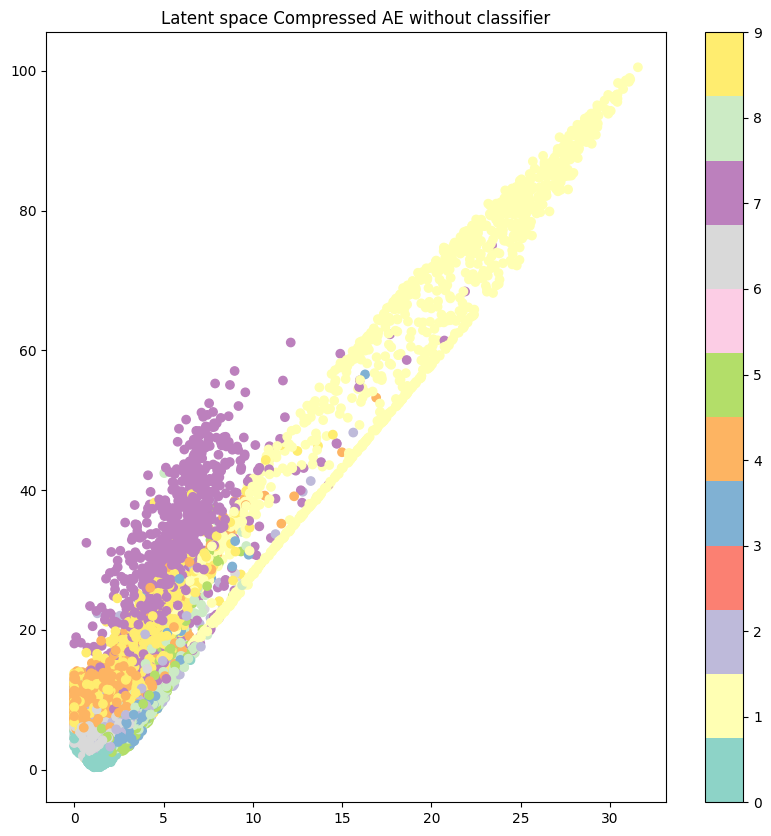

313/313 [==============================] - 1s 2ms/step


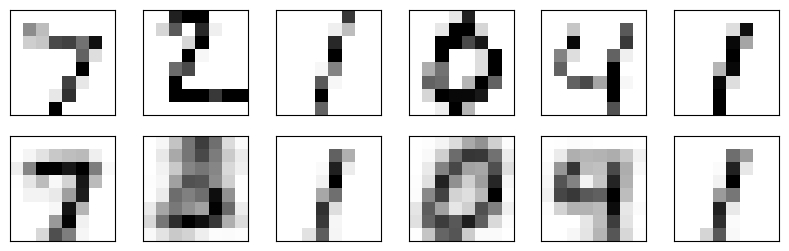

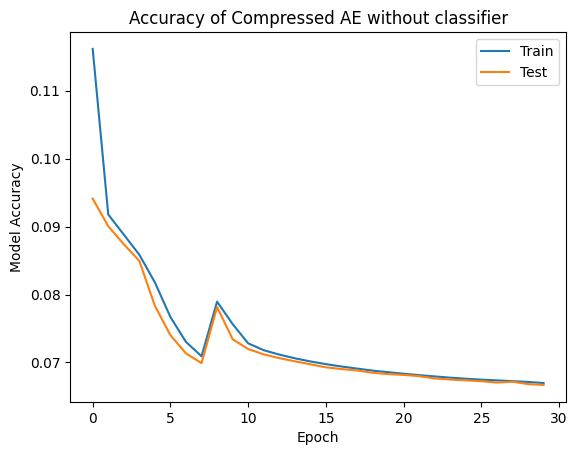

In [6]:
network = Autoencoder(data_zoom, pruned=True)
network.build_encoder()
network.build_decoder()
network.build_autoencoder()
network.fit_data()
network.plot_latent_dimension("Compressed AE without classifier")
network.plot_reco(model_name=" compressed")
network.plot_score(use_latent_classifier=False, model_name="Compressed AE without classifier")


Repeating the same procedure for the autoencoder with classifier.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 fc1 (Dense)                    (None, 15)           975         ['encoder_input[0][0]']          
                                                                                                  
 fc2 (Dense)                    (None, 15)           240         ['fc1[0][0]']                    
                                                                                                  
 fc2.1 (Dense)                  (None, 15)           240         ['fc2[0][0]']                    
                                                                                              


Epoch 1: val_loss improved from inf to 0.26067, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 20ms/step - loss: 0.3232 - ecoder_output_loss: 0.1193 - classifier_output_loss: 2.0395 - ecoder_output_accuracy: 0.0271 - classifier_output_accuracy: 0.2148 - val_loss: 0.2607 - val_ecoder_output_loss: 0.0955 - val_classifier_output_loss: 1.6513 - val_ecoder_output_accuracy: 0.0549 - val_classifier_output_accuracy: 0.3635 - lr: 0.0010
Epoch 2/30
226/235 [===========================>..] - ETA: 0s - loss: 0.2459 - ecoder_output_loss: 0.0947 - classifier_output_loss: 1.5124 - ecoder_output_accuracy: 0.0826 - classifier_output_accuracy: 0.4024
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 2: val_loss improved from 0.2606


Epoch 2: val_loss improved from 0.26067 to 0.23549, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 16ms/step - loss: 0.2455 - ecoder_output_loss: 0.0946 - classifier_output_loss: 1.5091 - ecoder_output_accuracy: 0.0829 - classifier_output_accuracy: 0.4042 - val_loss: 0.2355 - val_ecoder_output_loss: 0.0935 - val_classifier_output_loss: 1.4202 - val_ecoder_output_accuracy: 0.0847 - val_classifier_output_accuracy: 0.4317 - lr: 0.0010
Epoch 3/30
225/235 [===========================>..] - ETA: 0s - loss: 0.2297 - ecoder_output_loss: 0.0919 - classifier_output_loss: 1.3781 - ecoder_output_accuracy: 0.0840 - classifier_output_accuracy: 0.4639
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 3: val_loss improved from 0.


Epoch 3: val_loss improved from 0.23549 to 0.22173, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 17ms/step - loss: 0.2293 - ecoder_output_loss: 0.0919 - classifier_output_loss: 1.3744 - ecoder_output_accuracy: 0.0838 - classifier_output_accuracy: 0.4660 - val_loss: 0.2217 - val_ecoder_output_loss: 0.0901 - val_classifier_output_loss: 1.3165 - val_ecoder_output_accuracy: 0.0708 - val_classifier_output_accuracy: 0.5089 - lr: 0.0010
Epoch 4/30
228/235 [============================>.] - ETA: 0s - loss: 0.2162 - ecoder_output_loss: 0.0896 - classifier_output_loss: 1.2661 - ecoder_output_accuracy: 0.0707 - classifier_output_accuracy: 0.5222
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 4: val_loss improved from 0.


Epoch 4: val_loss improved from 0.22173 to 0.20980, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.2162 - ecoder_output_loss: 0.0896 - classifier_output_loss: 1.2655 - ecoder_output_accuracy: 0.0699 - classifier_output_accuracy: 0.5230 - val_loss: 0.2098 - val_ecoder_output_loss: 0.0889 - val_classifier_output_loss: 1.2090 - val_ecoder_output_accuracy: 0.0452 - val_classifier_output_accuracy: 0.5532 - lr: 0.0010
Epoch 5/30
229/235 [============================>.] - ETA: 0s - loss: 0.2062 - ecoder_output_loss: 0.0885 - classifier_output_loss: 1.1761 - ecoder_output_accuracy: 0.0393 - classifier_output_accuracy: 0.5704
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 5: val_loss improved from 0.


Epoch 5: val_loss improved from 0.20980 to 0.20175, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 15ms/step - loss: 0.2062 - ecoder_output_loss: 0.0886 - classifier_output_loss: 1.1763 - ecoder_output_accuracy: 0.0390 - classifier_output_accuracy: 0.5706 - val_loss: 0.2018 - val_ecoder_output_loss: 0.0875 - val_classifier_output_loss: 1.1421 - val_ecoder_output_accuracy: 0.0330 - val_classifier_output_accuracy: 0.5990 - lr: 0.0010
Epoch 6/30
229/235 [============================>.] - ETA: 0s - loss: 0.1984 - ecoder_output_loss: 0.0873 - classifier_output_loss: 1.1114 - ecoder_output_accuracy: 0.0312 - classifier_output_accuracy: 0.6005
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 6: val_loss improved from 0.


Epoch 6: val_loss improved from 0.20175 to 0.19431, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 17ms/step - loss: 0.1984 - ecoder_output_loss: 0.0873 - classifier_output_loss: 1.1113 - ecoder_output_accuracy: 0.0312 - classifier_output_accuracy: 0.6006 - val_loss: 0.1943 - val_ecoder_output_loss: 0.0865 - val_classifier_output_loss: 1.0785 - val_ecoder_output_accuracy: 0.0274 - val_classifier_output_accuracy: 0.6286 - lr: 0.0010
Epoch 7/30
232/235 [============================>.] - ETA: 0s - loss: 0.1927 - ecoder_output_loss: 0.0862 - classifier_output_loss: 1.0646 - ecoder_output_accuracy: 0.0319 - classifier_output_accuracy: 0.6184
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 7: val_loss improved from 0.


Epoch 7: val_loss improved from 0.19431 to 0.18963, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.1926 - ecoder_output_loss: 0.0862 - classifier_output_loss: 1.0643 - ecoder_output_accuracy: 0.0318 - classifier_output_accuracy: 0.6184 - val_loss: 0.1896 - val_ecoder_output_loss: 0.0854 - val_classifier_output_loss: 1.0427 - val_ecoder_output_accuracy: 0.0317 - val_classifier_output_accuracy: 0.6374 - lr: 0.0010
Epoch 8/30
232/235 [============================>.] - ETA: 0s - loss: 0.1880 - ecoder_output_loss: 0.0853 - classifier_output_loss: 1.0267 - ecoder_output_accuracy: 0.0367 - classifier_output_accuracy: 0.6356
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 8: val_loss improved from 0.


Epoch 8: val_loss improved from 0.18963 to 0.18554, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 30ms/step - loss: 0.1880 - ecoder_output_loss: 0.0853 - classifier_output_loss: 1.0265 - ecoder_output_accuracy: 0.0367 - classifier_output_accuracy: 0.6356 - val_loss: 0.1855 - val_ecoder_output_loss: 0.0847 - val_classifier_output_loss: 1.0089 - val_ecoder_output_accuracy: 0.0265 - val_classifier_output_accuracy: 0.6450 - lr: 0.0010
Epoch 9/30
230/235 [============================>.] - ETA: 0s - loss: 0.1842 - ecoder_output_loss: 0.0847 - classifier_output_loss: 0.9956 - ecoder_output_accuracy: 0.0369 - classifier_output_accuracy: 0.6469
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 9: val_loss improved from 0.


Epoch 9: val_loss improved from 0.18554 to 0.18350, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 9: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 9: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 9s 38ms/step - loss: 0.1842 - ecoder_output_loss: 0.0847 - classifier_output_loss: 0.9953 - ecoder_output_accuracy: 0.0371 - classifier_output_accuracy: 0.6470 - val_loss: 0.1835 - val_ecoder_output_loss: 0.0838 - val_classifier_output_loss: 0.9967 - val_ecoder_output_accuracy: 0.0342 - val_classifier_output_accuracy: 0.6510 - lr: 0.0010
Epoch 10/30
226/235 [===========================>..] - ETA: 0s - loss: 0.1806 - ecoder_output_loss: 0.0839 - classifier_output_loss: 0.9676 - ecoder_output_accuracy: 0.0390 - classifier_output_accuracy: 0.6607
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 10: val_loss improved from 


Epoch 10: val_loss improved from 0.18350 to 0.17890, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 10: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 10: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 10: saving model to model/AE_model/model_2\KERAS_check_model_epoch10.h5

***callbacks end***

235/235 [==============================] - 7s 31ms/step - loss: 0.1806 - ecoder_output_loss: 0.0838 - classifier_output_loss: 0.9674 - ecoder_output_accuracy: 0.0391 - classifier_output_accuracy: 0.6605 - val_loss: 0.1789 - val_ecoder_output_loss: 0.0833 - val_classifier_output_loss: 0.9563 - val_ecoder_output_accuracy: 0.0359 - val_classifier_output_accuracy: 0.6751 - lr: 0.0010
Epoch 11/30
234/235 [============================>.] - ETA: 0s - loss: 0.1776 - ecoder_output_loss: 0.0833 - classifier_output_loss: 0.9424 - ecoder_output_accuracy: 0.0409 - classifier_output_accuracy: 0.6723
***callbacks***
sav


Epoch 11: val_loss improved from 0.17890 to 0.17597, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 11: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 11: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 26ms/step - loss: 0.1776 - ecoder_output_loss: 0.0833 - classifier_output_loss: 0.9423 - ecoder_output_accuracy: 0.0409 - classifier_output_accuracy: 0.6724 - val_loss: 0.1760 - val_ecoder_output_loss: 0.0828 - val_classifier_output_loss: 0.9321 - val_ecoder_output_accuracy: 0.0419 - val_classifier_output_accuracy: 0.6787 - lr: 0.0010
Epoch 12/30
226/235 [===========================>..] - ETA: 0s - loss: 0.1747 - ecoder_output_loss: 0.0829 - classifier_output_loss: 0.9180 - ecoder_output_accuracy: 0.0440 - classifier_output_accuracy: 0.6821
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 12: val_loss improved fr


Epoch 12: val_loss improved from 0.17597 to 0.17248, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 12: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 12: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.1746 - ecoder_output_loss: 0.0829 - classifier_output_loss: 0.9167 - ecoder_output_accuracy: 0.0441 - classifier_output_accuracy: 0.6826 - val_loss: 0.1725 - val_ecoder_output_loss: 0.0822 - val_classifier_output_loss: 0.9026 - val_ecoder_output_accuracy: 0.0416 - val_classifier_output_accuracy: 0.6961 - lr: 0.0010
Epoch 13/30
228/235 [============================>.] - ETA: 0s - loss: 0.1719 - ecoder_output_loss: 0.0825 - classifier_output_loss: 0.8944 - ecoder_output_accuracy: 0.0428 - classifier_output_accuracy: 0.6921
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 13: val_loss improved fr


Epoch 13: val_loss improved from 0.17248 to 0.16973, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 13: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 13: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 21ms/step - loss: 0.1718 - ecoder_output_loss: 0.0825 - classifier_output_loss: 0.8935 - ecoder_output_accuracy: 0.0427 - classifier_output_accuracy: 0.6929 - val_loss: 0.1697 - val_ecoder_output_loss: 0.0819 - val_classifier_output_loss: 0.8779 - val_ecoder_output_accuracy: 0.0354 - val_classifier_output_accuracy: 0.7105 - lr: 0.0010
Epoch 14/30
227/235 [===========================>..] - ETA: 0s - loss: 0.1691 - ecoder_output_loss: 0.0821 - classifier_output_loss: 0.8703 - ecoder_output_accuracy: 0.0434 - classifier_output_accuracy: 0.7042
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 14: val_loss did not imp


Epoch 15: val_loss improved from 0.16973 to 0.16522, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 15: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 15: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 23ms/step - loss: 0.1663 - ecoder_output_loss: 0.0817 - classifier_output_loss: 0.8456 - ecoder_output_accuracy: 0.0419 - classifier_output_accuracy: 0.7150 - val_loss: 0.1652 - val_ecoder_output_loss: 0.0811 - val_classifier_output_loss: 0.8412 - val_ecoder_output_accuracy: 0.0496 - val_classifier_output_accuracy: 0.7253 - lr: 0.0010
Epoch 16/30
235/235 [==============================] - ETA: 0s - loss: 0.1637 - ecoder_output_loss: 0.0814 - classifier_output_loss: 0.8228 - ecoder_output_accuracy: 0.0452 - classifier_output_accuracy: 0.7278
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 16: val_loss improved fr


Epoch 16: val_loss improved from 0.16522 to 0.16177, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 16: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 16: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 17ms/step - loss: 0.1637 - ecoder_output_loss: 0.0814 - classifier_output_loss: 0.8228 - ecoder_output_accuracy: 0.0452 - classifier_output_accuracy: 0.7278 - val_loss: 0.1618 - val_ecoder_output_loss: 0.0809 - val_classifier_output_loss: 0.8088 - val_ecoder_output_accuracy: 0.0457 - val_classifier_output_accuracy: 0.7447 - lr: 0.0010
Epoch 17/30
226/235 [===========================>..] - ETA: 0s - loss: 0.1610 - ecoder_output_loss: 0.0812 - classifier_output_loss: 0.7982 - ecoder_output_accuracy: 0.0470 - classifier_output_accuracy: 0.7379
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 17: val_loss improved fr


Epoch 17: val_loss improved from 0.16177 to 0.15989, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 17: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 17: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 23ms/step - loss: 0.1611 - ecoder_output_loss: 0.0812 - classifier_output_loss: 0.7989 - ecoder_output_accuracy: 0.0469 - classifier_output_accuracy: 0.7380 - val_loss: 0.1599 - val_ecoder_output_loss: 0.0808 - val_classifier_output_loss: 0.7914 - val_ecoder_output_accuracy: 0.0305 - val_classifier_output_accuracy: 0.7455 - lr: 0.0010
Epoch 18/30
230/235 [============================>.] - ETA: 0s - loss: 0.1587 - ecoder_output_loss: 0.0809 - classifier_output_loss: 0.7779 - ecoder_output_accuracy: 0.0494 - classifier_output_accuracy: 0.7456
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 18: val_loss improved fr


Epoch 18: val_loss improved from 0.15989 to 0.15801, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 30ms/step - loss: 0.1587 - ecoder_output_loss: 0.0809 - classifier_output_loss: 0.7772 - ecoder_output_accuracy: 0.0494 - classifier_output_accuracy: 0.7456 - val_loss: 0.1580 - val_ecoder_output_loss: 0.0804 - val_classifier_output_loss: 0.7761 - val_ecoder_output_accuracy: 0.0443 - val_classifier_output_accuracy: 0.7570 - lr: 0.0010
Epoch 19/30
229/235 [============================>.] - ETA: 0s - loss: 0.1567 - ecoder_output_loss: 0.0807 - classifier_output_loss: 0.7604 - ecoder_output_accuracy: 0.0493 - classifier_output_accuracy: 0.7526
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 19: val_loss improved fr


Epoch 19: val_loss improved from 0.15801 to 0.15650, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 27ms/step - loss: 0.1568 - ecoder_output_loss: 0.0807 - classifier_output_loss: 0.7608 - ecoder_output_accuracy: 0.0493 - classifier_output_accuracy: 0.7525 - val_loss: 0.1565 - val_ecoder_output_loss: 0.0803 - val_classifier_output_loss: 0.7622 - val_ecoder_output_accuracy: 0.0330 - val_classifier_output_accuracy: 0.7578 - lr: 0.0010
Epoch 20/30
227/235 [===========================>..] - ETA: 0s - loss: 0.1547 - ecoder_output_loss: 0.0805 - classifier_output_loss: 0.7420 - ecoder_output_accuracy: 0.0473 - classifier_output_accuracy: 0.7584
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 20: val_loss improved fr


Epoch 20: val_loss improved from 0.15650 to 0.15472, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_epoch20.h5

***callbacks end***

235/235 [==============================] - 5s 22ms/step - loss: 0.1547 - ecoder_output_loss: 0.0805 - classifier_output_loss: 0.7422 - ecoder_output_accuracy: 0.0471 - classifier_output_accuracy: 0.7584 - val_loss: 0.1547 - val_ecoder_output_loss: 0.0800 - val_classifier_output_loss: 0.7473 - val_ecoder_output_accuracy: 0.0431 - val_classifier_output_accuracy: 0.7613 - lr: 0.0010
Epoch 21/30
229/235 [============================>.] - ETA: 0s - loss: 0.1530 - ecoder_output_loss: 0.0804 - classifier_output_loss: 0.7266 - ecoder_output_accuracy: 0.0473 - classifier_output_accuracy: 0.7639
***callbacks***
sav


Epoch 21: val_loss improved from 0.15472 to 0.15239, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 19ms/step - loss: 0.1531 - ecoder_output_loss: 0.0804 - classifier_output_loss: 0.7271 - ecoder_output_accuracy: 0.0468 - classifier_output_accuracy: 0.7637 - val_loss: 0.1524 - val_ecoder_output_loss: 0.0799 - val_classifier_output_loss: 0.7254 - val_ecoder_output_accuracy: 0.0333 - val_classifier_output_accuracy: 0.7708 - lr: 0.0010
Epoch 22/30
226/235 [===========================>..] - ETA: 0s - loss: 0.1519 - ecoder_output_loss: 0.0802 - classifier_output_loss: 0.7166 - ecoder_output_accuracy: 0.0465 - classifier_output_accuracy: 0.7689
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 22: val_loss improved fr


Epoch 22: val_loss improved from 0.15239 to 0.15134, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 17ms/step - loss: 0.1517 - ecoder_output_loss: 0.0802 - classifier_output_loss: 0.7151 - ecoder_output_accuracy: 0.0461 - classifier_output_accuracy: 0.7695 - val_loss: 0.1513 - val_ecoder_output_loss: 0.0799 - val_classifier_output_loss: 0.7142 - val_ecoder_output_accuracy: 0.0383 - val_classifier_output_accuracy: 0.7772 - lr: 0.0010
Epoch 23/30
229/235 [============================>.] - ETA: 0s - loss: 0.1504 - ecoder_output_loss: 0.0801 - classifier_output_loss: 0.7037 - ecoder_output_accuracy: 0.0444 - classifier_output_accuracy: 0.7740
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 23: val_loss improved fr


Epoch 23: val_loss improved from 0.15134 to 0.15024, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 22ms/step - loss: 0.1505 - ecoder_output_loss: 0.0801 - classifier_output_loss: 0.7036 - ecoder_output_accuracy: 0.0446 - classifier_output_accuracy: 0.7739 - val_loss: 0.1502 - val_ecoder_output_loss: 0.0797 - val_classifier_output_loss: 0.7056 - val_ecoder_output_accuracy: 0.0464 - val_classifier_output_accuracy: 0.7768 - lr: 0.0010
Epoch 24/30
229/235 [============================>.] - ETA: 0s - loss: 0.1488 - ecoder_output_loss: 0.0799 - classifier_output_loss: 0.6894 - ecoder_output_accuracy: 0.0462 - classifier_output_accuracy: 0.7797
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 24: val_loss improved fr


Epoch 24: val_loss improved from 0.15024 to 0.14890, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 21ms/step - loss: 0.1490 - ecoder_output_loss: 0.0799 - classifier_output_loss: 0.6904 - ecoder_output_accuracy: 0.0465 - classifier_output_accuracy: 0.7798 - val_loss: 0.1489 - val_ecoder_output_loss: 0.0794 - val_classifier_output_loss: 0.6946 - val_ecoder_output_accuracy: 0.0424 - val_classifier_output_accuracy: 0.7881 - lr: 0.0010
Epoch 25/30
230/235 [============================>.] - ETA: 0s - loss: 0.1477 - ecoder_output_loss: 0.0799 - classifier_output_loss: 0.6782 - ecoder_output_accuracy: 0.0463 - classifier_output_accuracy: 0.7851
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 25: val_loss improved fr


Epoch 25: val_loss improved from 0.14890 to 0.14809, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 18ms/step - loss: 0.1476 - ecoder_output_loss: 0.0798 - classifier_output_loss: 0.6780 - ecoder_output_accuracy: 0.0463 - classifier_output_accuracy: 0.7852 - val_loss: 0.1481 - val_ecoder_output_loss: 0.0795 - val_classifier_output_loss: 0.6861 - val_ecoder_output_accuracy: 0.0468 - val_classifier_output_accuracy: 0.7791 - lr: 0.0010
Epoch 26/30
232/235 [============================>.] - ETA: 0s - loss: 0.1465 - ecoder_output_loss: 0.0798 - classifier_output_loss: 0.6674 - ecoder_output_accuracy: 0.0467 - classifier_output_accuracy: 0.7892
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 26: val_loss improved fr


Epoch 26: val_loss improved from 0.14809 to 0.14702, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.1466 - ecoder_output_loss: 0.0798 - classifier_output_loss: 0.6678 - ecoder_output_accuracy: 0.0468 - classifier_output_accuracy: 0.7891 - val_loss: 0.1470 - val_ecoder_output_loss: 0.0795 - val_classifier_output_loss: 0.6747 - val_ecoder_output_accuracy: 0.0365 - val_classifier_output_accuracy: 0.7975 - lr: 0.0010
Epoch 27/30
227/235 [===========================>..] - ETA: 0s - loss: 0.1458 - ecoder_output_loss: 0.0798 - classifier_output_loss: 0.6608 - ecoder_output_accuracy: 0.0463 - classifier_output_accuracy: 0.7909
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 27: val_loss did not imp


Epoch 28: val_loss improved from 0.14702 to 0.14644, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 28: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 28: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 5s 20ms/step - loss: 0.1448 - ecoder_output_loss: 0.0796 - classifier_output_loss: 0.6514 - ecoder_output_accuracy: 0.0468 - classifier_output_accuracy: 0.7966 - val_loss: 0.1464 - val_ecoder_output_loss: 0.0794 - val_classifier_output_loss: 0.6706 - val_ecoder_output_accuracy: 0.0404 - val_classifier_output_accuracy: 0.8044 - lr: 0.0010
Epoch 29/30
226/235 [===========================>..] - ETA: 0s - loss: 0.1439 - ecoder_output_loss: 0.0795 - classifier_output_loss: 0.6440 - ecoder_output_accuracy: 0.0474 - classifier_output_accuracy: 0.7993
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 29: val_loss improved fr


Epoch 29: val_loss improved from 0.14644 to 0.14430, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 4s 17ms/step - loss: 0.1440 - ecoder_output_loss: 0.0796 - classifier_output_loss: 0.6439 - ecoder_output_accuracy: 0.0474 - classifier_output_accuracy: 0.7991 - val_loss: 0.1443 - val_ecoder_output_loss: 0.0791 - val_classifier_output_loss: 0.6517 - val_ecoder_output_accuracy: 0.0519 - val_classifier_output_accuracy: 0.8052 - lr: 0.0010
Epoch 30/30
230/235 [============================>.] - ETA: 0s - loss: 0.1435 - ecoder_output_loss: 0.0796 - classifier_output_loss: 0.6397 - ecoder_output_accuracy: 0.0457 - classifier_output_accuracy: 0.8037
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 30: val_loss did not imp

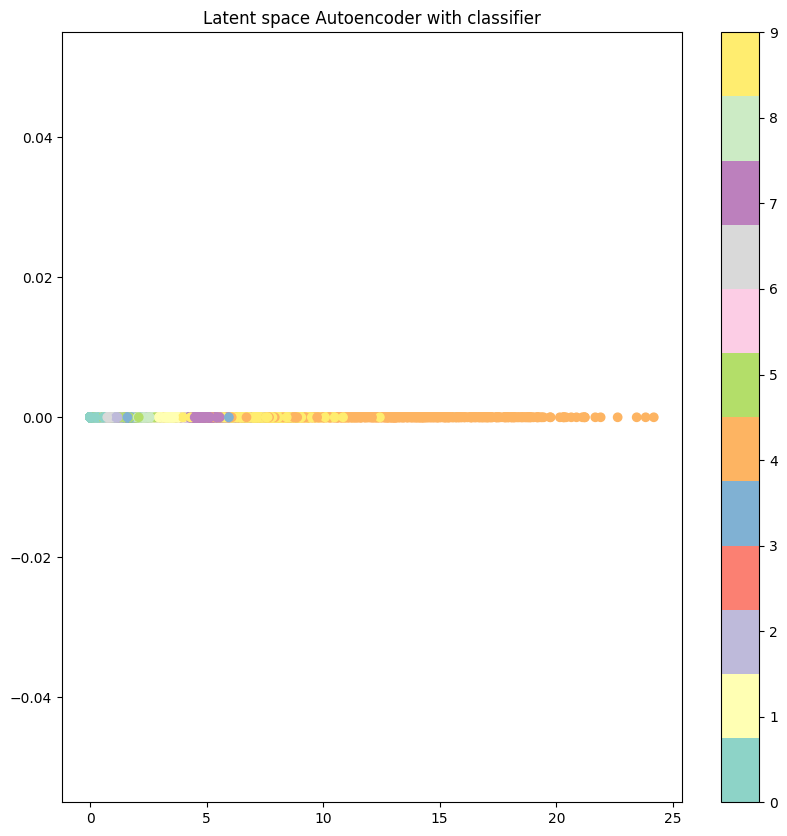

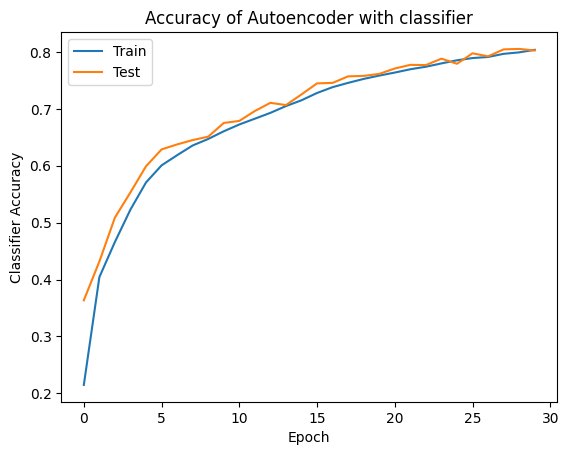

In [7]:
network_with_classifier = Autoencoder(data_zoom, pruned=False)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_autoencoder(use_latent_classifier=True)
network_with_classifier.fit_data( batch_size=256,epochs=30, use_latent_classifier=True)
network_with_classifier.plot_latent_dimension("Autoencoder with classifier")
network_with_classifier.plot_score(use_latent_classifier=True,model_name="Autoencoder with classifier")

In [8]:
import time

img = data_zoom.x_test[0].reshape(1,-1)
start_time = time.time()
network_with_classifier.autoencoder.predict(img)[1]
print("--- %s seconds ---" % (time.time() - start_time))

1/1 [==============================] - 0s 223ms/step
--- 0.30637192726135254 seconds ---


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 fc1 (Dense)                    (None, 15)           975         ['encoder_input[0][0]']          
                                                                                                  
 prune_low_magnitude_fc2_prun (  (None, 15)          467         ['fc1[0][0]']                    
 PruneLowMagnitude)                                                                               
                                                                                                  
 prune_low_magnitude_fc2.1_prun  (None, 15)          467         ['prune_low_magnitude_fc2_p


Epoch 1: val_loss improved from inf to 0.24434, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 1: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 14s 38ms/step - loss: 0.3269 - ecoder_output_loss: 0.1262 - classifier_output_loss: 2.0066 - ecoder_output_accuracy: 0.0253 - classifier_output_accuracy: 0.2182 - val_loss: 0.2443 - val_ecoder_output_loss: 0.0914 - val_classifier_output_loss: 1.5290 - val_ecoder_output_accuracy: 0.0360 - val_classifier_output_accuracy: 0.3826 - lr: 0.0010
Epoch 2/30
227/235 [===========================>..] - ETA: 0s - loss: 0.2208 - ecoder_output_loss: 0.0889 - classifier_output_loss: 1.3196 - ecoder_output_accuracy: 0.0630 - classifier_output_accuracy: 0.4989
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 2: val_loss improved from 0.244


Epoch 2: val_loss improved from 0.24434 to 0.19261, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 2: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 35ms/step - loss: 0.2200 - ecoder_output_loss: 0.0888 - classifier_output_loss: 1.3119 - ecoder_output_accuracy: 0.0626 - classifier_output_accuracy: 0.5017 - val_loss: 0.1926 - val_ecoder_output_loss: 0.0871 - val_classifier_output_loss: 1.0550 - val_ecoder_output_accuracy: 0.0544 - val_classifier_output_accuracy: 0.6127 - lr: 0.0010
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.1801 - ecoder_output_loss: 0.0850 - classifier_output_loss: 0.9513 - ecoder_output_accuracy: 0.0462 - classifier_output_accuracy: 0.6826
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 3: val_loss improved from 0.


Epoch 3: val_loss improved from 0.19261 to 0.15984, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 3: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 9s 40ms/step - loss: 0.1801 - ecoder_output_loss: 0.0850 - classifier_output_loss: 0.9513 - ecoder_output_accuracy: 0.0462 - classifier_output_accuracy: 0.6826 - val_loss: 0.1598 - val_ecoder_output_loss: 0.0801 - val_classifier_output_loss: 0.7970 - val_ecoder_output_accuracy: 0.0349 - val_classifier_output_accuracy: 0.7484 - lr: 0.0010
Epoch 4/30
234/235 [============================>.] - ETA: 0s - loss: 0.1576 - ecoder_output_loss: 0.0795 - classifier_output_loss: 0.7806 - ecoder_output_accuracy: 0.0400 - classifier_output_accuracy: 0.7620
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 4: val_loss improved from 0.


Epoch 4: val_loss improved from 0.15984 to 0.14828, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 4: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 32ms/step - loss: 0.1575 - ecoder_output_loss: 0.0795 - classifier_output_loss: 0.7804 - ecoder_output_accuracy: 0.0400 - classifier_output_accuracy: 0.7620 - val_loss: 0.1483 - val_ecoder_output_loss: 0.0782 - val_classifier_output_loss: 0.7012 - val_ecoder_output_accuracy: 0.0420 - val_classifier_output_accuracy: 0.7902 - lr: 0.0010
Epoch 5/30
234/235 [============================>.] - ETA: 0s - loss: 0.1483 - ecoder_output_loss: 0.0784 - classifier_output_loss: 0.6989 - ecoder_output_accuracy: 0.0425 - classifier_output_accuracy: 0.7938
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 5: val_loss improved from 0.


Epoch 5: val_loss improved from 0.14828 to 0.14150, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 5: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.1483 - ecoder_output_loss: 0.0784 - classifier_output_loss: 0.6991 - ecoder_output_accuracy: 0.0424 - classifier_output_accuracy: 0.7938 - val_loss: 0.1415 - val_ecoder_output_loss: 0.0774 - val_classifier_output_loss: 0.6405 - val_ecoder_output_accuracy: 0.0342 - val_classifier_output_accuracy: 0.8141 - lr: 0.0010
Epoch 6/30
226/235 [===========================>..] - ETA: 0s - loss: 0.1422 - ecoder_output_loss: 0.0778 - classifier_output_loss: 0.6442 - ecoder_output_accuracy: 0.0515 - classifier_output_accuracy: 0.8122
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 6: val_loss improved from 0.


Epoch 6: val_loss improved from 0.14150 to 0.13639, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 6: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 6s 28ms/step - loss: 0.1420 - ecoder_output_loss: 0.0777 - classifier_output_loss: 0.6426 - ecoder_output_accuracy: 0.0521 - classifier_output_accuracy: 0.8126 - val_loss: 0.1364 - val_ecoder_output_loss: 0.0768 - val_classifier_output_loss: 0.5955 - val_ecoder_output_accuracy: 0.0510 - val_classifier_output_accuracy: 0.8287 - lr: 0.0010
Epoch 7/30
228/235 [============================>.] - ETA: 0s - loss: 0.1375 - ecoder_output_loss: 0.0772 - classifier_output_loss: 0.6031 - ecoder_output_accuracy: 0.0677 - classifier_output_accuracy: 0.8277
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 7: val_loss improved from 0.


Epoch 7: val_loss improved from 0.13639 to 0.13320, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 7: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 33ms/step - loss: 0.1374 - ecoder_output_loss: 0.0771 - classifier_output_loss: 0.6024 - ecoder_output_accuracy: 0.0675 - classifier_output_accuracy: 0.8282 - val_loss: 0.1332 - val_ecoder_output_loss: 0.0760 - val_classifier_output_loss: 0.5716 - val_ecoder_output_accuracy: 0.0628 - val_classifier_output_accuracy: 0.8381 - lr: 0.0010
Epoch 8/30
227/235 [===========================>..] - ETA: 0s - loss: 0.1340 - ecoder_output_loss: 0.0765 - classifier_output_loss: 0.5749 - ecoder_output_accuracy: 0.0743 - classifier_output_accuracy: 0.8381
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 8: val_loss improved from 0.


Epoch 8: val_loss improved from 0.13320 to 0.13027, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 8: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.1340 - ecoder_output_loss: 0.0766 - classifier_output_loss: 0.5747 - ecoder_output_accuracy: 0.0742 - classifier_output_accuracy: 0.8384 - val_loss: 0.1303 - val_ecoder_output_loss: 0.0757 - val_classifier_output_loss: 0.5452 - val_ecoder_output_accuracy: 0.0613 - val_classifier_output_accuracy: 0.8472 - lr: 0.0010
Epoch 9/30
227/235 [===========================>..] - ETA: 0s - loss: 0.2014 - ecoder_output_loss: 0.0823 - classifier_output_loss: 1.1915 - ecoder_output_accuracy: 0.0613 - classifier_output_accuracy: 0.6583
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 9: val_loss did not improve 


Epoch 18: val_loss improved from 0.13027 to 0.12960, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 18: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 30ms/step - loss: 0.1327 - ecoder_output_loss: 0.0763 - classifier_output_loss: 0.5638 - ecoder_output_accuracy: 0.0726 - classifier_output_accuracy: 0.8500 - val_loss: 0.1296 - val_ecoder_output_loss: 0.0757 - val_classifier_output_loss: 0.5387 - val_ecoder_output_accuracy: 0.0651 - val_classifier_output_accuracy: 0.8574 - lr: 0.0010
Epoch 19/30
231/235 [============================>.] - ETA: 0s - loss: 0.1314 - ecoder_output_loss: 0.0760 - classifier_output_loss: 0.5532 - ecoder_output_accuracy: 0.0724 - classifier_output_accuracy: 0.8534
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 19: val_loss improved fr


Epoch 19: val_loss improved from 0.12960 to 0.12879, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 19: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 13s 54ms/step - loss: 0.1314 - ecoder_output_loss: 0.0760 - classifier_output_loss: 0.5539 - ecoder_output_accuracy: 0.0724 - classifier_output_accuracy: 0.8531 - val_loss: 0.1288 - val_ecoder_output_loss: 0.0755 - val_classifier_output_loss: 0.5329 - val_ecoder_output_accuracy: 0.0663 - val_classifier_output_accuracy: 0.8555 - lr: 0.0010
Epoch 20/30
231/235 [============================>.] - ETA: 0s - loss: 0.1304 - ecoder_output_loss: 0.0759 - classifier_output_loss: 0.5452 - ecoder_output_accuracy: 0.0712 - classifier_output_accuracy: 0.8560
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 20: val_loss improved f


Epoch 20: val_loss improved from 0.12879 to 0.12810, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

Epoch 20: saving model to model/AE_model/model_2\KERAS_check_model_epoch20.h5

***callbacks end***

235/235 [==============================] - 9s 38ms/step - loss: 0.1304 - ecoder_output_loss: 0.0759 - classifier_output_loss: 0.5451 - ecoder_output_accuracy: 0.0713 - classifier_output_accuracy: 0.8559 - val_loss: 0.1281 - val_ecoder_output_loss: 0.0755 - val_classifier_output_loss: 0.5259 - val_ecoder_output_accuracy: 0.0662 - val_classifier_output_accuracy: 0.8583 - lr: 0.0010
Epoch 21/30
231/235 [============================>.] - ETA: 0s - loss: 0.1293 - ecoder_output_loss: 0.0757 - classifier_output_loss: 0.5360 - ecoder_output_accuracy: 0.0707 - classifier_output_accuracy: 0.8589
***callbacks***
sav


Epoch 21: val_loss improved from 0.12810 to 0.12682, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 21: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.1293 - ecoder_output_loss: 0.0757 - classifier_output_loss: 0.5365 - ecoder_output_accuracy: 0.0705 - classifier_output_accuracy: 0.8587 - val_loss: 0.1268 - val_ecoder_output_loss: 0.0752 - val_classifier_output_loss: 0.5165 - val_ecoder_output_accuracy: 0.0637 - val_classifier_output_accuracy: 0.8636 - lr: 0.0010
Epoch 22/30
224/235 [===========================>..] - ETA: 0s - loss: 0.1284 - ecoder_output_loss: 0.0754 - classifier_output_loss: 0.5299 - ecoder_output_accuracy: 0.0694 - classifier_output_accuracy: 0.8604
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 22: val_loss improved fr


Epoch 22: val_loss improved from 0.12682 to 0.12561, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 22: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 31ms/step - loss: 0.1284 - ecoder_output_loss: 0.0755 - classifier_output_loss: 0.5293 - ecoder_output_accuracy: 0.0693 - classifier_output_accuracy: 0.8605 - val_loss: 0.1256 - val_ecoder_output_loss: 0.0749 - val_classifier_output_loss: 0.5068 - val_ecoder_output_accuracy: 0.0697 - val_classifier_output_accuracy: 0.8655 - lr: 0.0010
Epoch 23/30
229/235 [============================>.] - ETA: 0s - loss: 0.1275 - ecoder_output_loss: 0.0753 - classifier_output_loss: 0.5225 - ecoder_output_accuracy: 0.0692 - classifier_output_accuracy: 0.8613
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 23: val_loss improved fr


Epoch 23: val_loss improved from 0.12561 to 0.12521, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 23: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 30ms/step - loss: 0.1276 - ecoder_output_loss: 0.0753 - classifier_output_loss: 0.5228 - ecoder_output_accuracy: 0.0691 - classifier_output_accuracy: 0.8614 - val_loss: 0.1252 - val_ecoder_output_loss: 0.0748 - val_classifier_output_loss: 0.5040 - val_ecoder_output_accuracy: 0.0602 - val_classifier_output_accuracy: 0.8665 - lr: 0.0010
Epoch 24/30
227/235 [===========================>..] - ETA: 0s - loss: 0.1267 - ecoder_output_loss: 0.0752 - classifier_output_loss: 0.5158 - ecoder_output_accuracy: 0.0693 - classifier_output_accuracy: 0.8641
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 24: val_loss improved fr


Epoch 24: val_loss improved from 0.12521 to 0.12504, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 24: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 8s 33ms/step - loss: 0.1268 - ecoder_output_loss: 0.0752 - classifier_output_loss: 0.5163 - ecoder_output_accuracy: 0.0692 - classifier_output_accuracy: 0.8641 - val_loss: 0.1250 - val_ecoder_output_loss: 0.0748 - val_classifier_output_loss: 0.5023 - val_ecoder_output_accuracy: 0.0630 - val_classifier_output_accuracy: 0.8651 - lr: 0.0010
Epoch 25/30
228/235 [============================>.] - ETA: 0s - loss: 0.1262 - ecoder_output_loss: 0.0750 - classifier_output_loss: 0.5111 - ecoder_output_accuracy: 0.0673 - classifier_output_accuracy: 0.8652
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 25: val_loss improved fr


Epoch 25: val_loss improved from 0.12504 to 0.12382, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 25: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 30ms/step - loss: 0.1261 - ecoder_output_loss: 0.0750 - classifier_output_loss: 0.5105 - ecoder_output_accuracy: 0.0674 - classifier_output_accuracy: 0.8653 - val_loss: 0.1238 - val_ecoder_output_loss: 0.0745 - val_classifier_output_loss: 0.4935 - val_ecoder_output_accuracy: 0.0587 - val_classifier_output_accuracy: 0.8683 - lr: 0.0010
Epoch 26/30
229/235 [============================>.] - ETA: 0s - loss: 0.1255 - ecoder_output_loss: 0.0748 - classifier_output_loss: 0.5070 - ecoder_output_accuracy: 0.0688 - classifier_output_accuracy: 0.8657
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 26: val_loss improved fr


Epoch 26: val_loss improved from 0.12382 to 0.12346, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 26: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 31ms/step - loss: 0.1255 - ecoder_output_loss: 0.0748 - classifier_output_loss: 0.5065 - ecoder_output_accuracy: 0.0690 - classifier_output_accuracy: 0.8657 - val_loss: 0.1235 - val_ecoder_output_loss: 0.0743 - val_classifier_output_loss: 0.4912 - val_ecoder_output_accuracy: 0.0566 - val_classifier_output_accuracy: 0.8698 - lr: 0.0010
Epoch 27/30
230/235 [============================>.] - ETA: 0s - loss: 0.1250 - ecoder_output_loss: 0.0746 - classifier_output_loss: 0.5038 - ecoder_output_accuracy: 0.0685 - classifier_output_accuracy: 0.8663
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 27: val_loss improved fr


Epoch 27: val_loss improved from 0.12346 to 0.12250, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 27: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 27: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 29ms/step - loss: 0.1249 - ecoder_output_loss: 0.0746 - classifier_output_loss: 0.5026 - ecoder_output_accuracy: 0.0685 - classifier_output_accuracy: 0.8667 - val_loss: 0.1225 - val_ecoder_output_loss: 0.0740 - val_classifier_output_loss: 0.4853 - val_ecoder_output_accuracy: 0.0571 - val_classifier_output_accuracy: 0.8722 - lr: 0.0010
Epoch 28/30
234/235 [============================>.] - ETA: 0s - loss: 0.1242 - ecoder_output_loss: 0.0744 - classifier_output_loss: 0.4977 - ecoder_output_accuracy: 0.0685 - classifier_output_accuracy: 0.8690
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 28: val_loss did not imp


Epoch 29: val_loss improved from 0.12250 to 0.12171, saving model to model/AE_model/model_2\KERAS_check_best_model_weights.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last.h5

Epoch 29: saving model to model/AE_model/model_2\KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 7s 31ms/step - loss: 0.1237 - ecoder_output_loss: 0.0743 - classifier_output_loss: 0.4948 - ecoder_output_accuracy: 0.0688 - classifier_output_accuracy: 0.8692 - val_loss: 0.1217 - val_ecoder_output_loss: 0.0738 - val_classifier_output_loss: 0.4791 - val_ecoder_output_accuracy: 0.0688 - val_classifier_output_accuracy: 0.8748 - lr: 0.0010
Epoch 30/30
224/235 [===========================>..] - ETA: 0s - loss: 0.1233 - ecoder_output_loss: 0.0741 - classifier_output_loss: 0.4921 - ecoder_output_accuracy: 0.0700 - classifier_output_accuracy: 0.8704
***callbacks***
saving losses to model/AE_model/model_2\losses.log

Epoch 30: val_loss did not imp

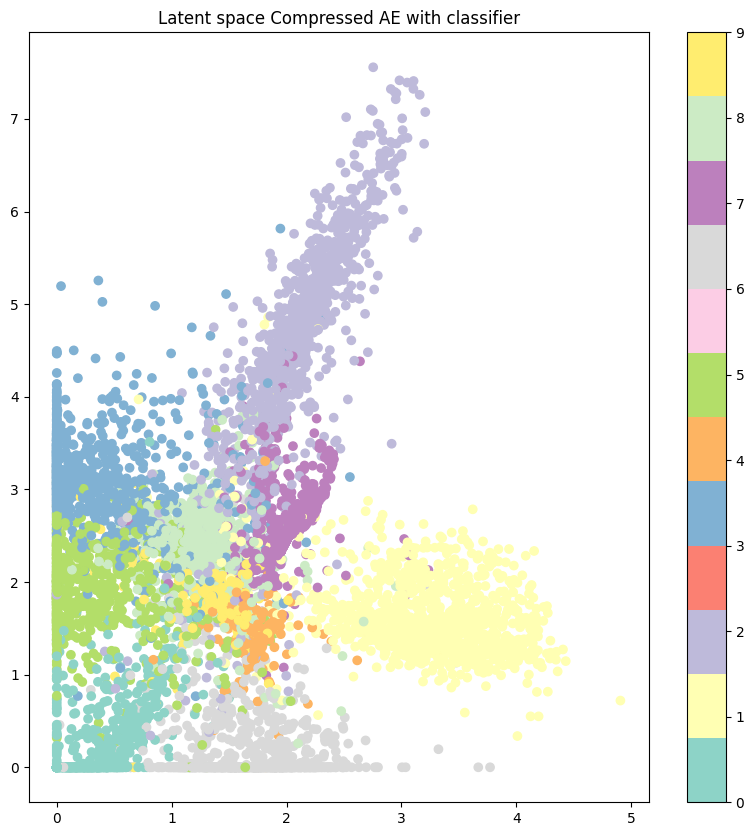

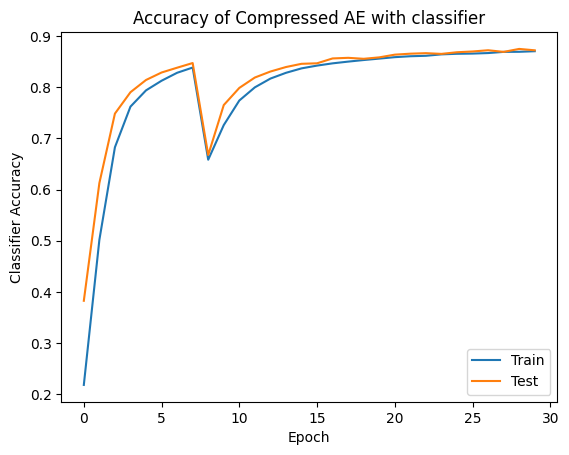

In [9]:
network_with_classifier = Autoencoder(data_zoom, pruned=True)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_autoencoder(use_latent_classifier=True)
network_with_classifier.fit_data(use_latent_classifier=True)
network_with_classifier.plot_latent_dimension("Compressed AE with classifier")
network_with_classifier.plot_score(use_latent_classifier=True,model_name="Compressed AE with classifier")

In [11]:

img = data_zoom.x_test[0].reshape(1,-1)
start_time = time.time()
network_with_classifier.autoencoder.predict(img)
print("--- %s seconds ---" % (time.time() - start_time))

1/1 [==============================] - 0s 61ms/step
--- 0.1691746711730957 seconds ---


In [12]:
img

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.4375 , 0.25   , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.1875 , 0.21875, 0.6875 , 0.71875,
        0.53125, 0.90625, 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.59375, 0.125  , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.96875, 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.71875, 0.09375, 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.09375, 0.78125, 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.96875, 0.     , 0.     , 0.     ,
        0.     ]])

In [13]:
network_with_classifier.autoencoder.predict(img)

1/1 [==============================] - 0s 32ms/step


[array([[9.13989425e-05, 2.75266077e-03, 2.85998476e-03, 8.96957051e-03,
         2.15529054e-02, 1.32914064e-02, 1.51268132e-02, 4.61397576e-05,
         5.96715789e-03, 1.34225562e-01, 2.48336837e-01, 2.95578420e-01,
         2.97415555e-01, 2.10903049e-01, 1.19869374e-01, 2.57778243e-04,
         1.51924849e-01, 4.47311878e-01, 6.19162798e-01, 6.34431481e-01,
         6.36285603e-01, 7.23184407e-01, 3.57923657e-01, 2.46245433e-02,
         3.28614376e-02, 7.79798329e-02, 7.60027990e-02, 2.22842563e-02,
         1.69666842e-01, 6.98251963e-01, 2.37009108e-01, 7.82040661e-06,
         9.11646616e-03, 1.36869606e-02, 6.50906488e-02, 5.15477210e-02,
         3.96550477e-01, 5.94932139e-01, 1.05815247e-01, 3.43880442e-04,
         1.53303752e-03, 5.37041724e-02, 5.95174246e-02, 1.76695913e-01,
         7.28482425e-01, 2.78272599e-01, 6.08591288e-02, 1.63888130e-02,
         6.51754381e-04, 1.50490738e-02, 3.39235999e-02, 4.27256227e-01,
         5.11425674e-01, 1.45888269e-01, 3.45789902

313/313 [==============================] - 1s 3ms/step


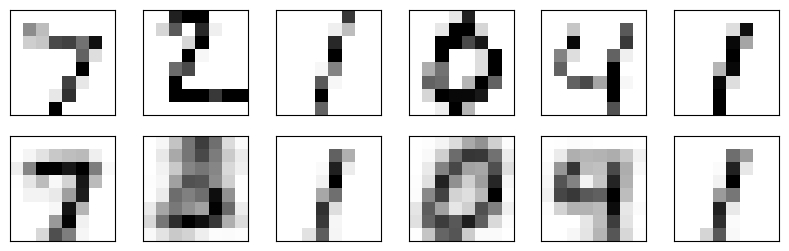

In [14]:
network.plot_reco(model_name="complete")


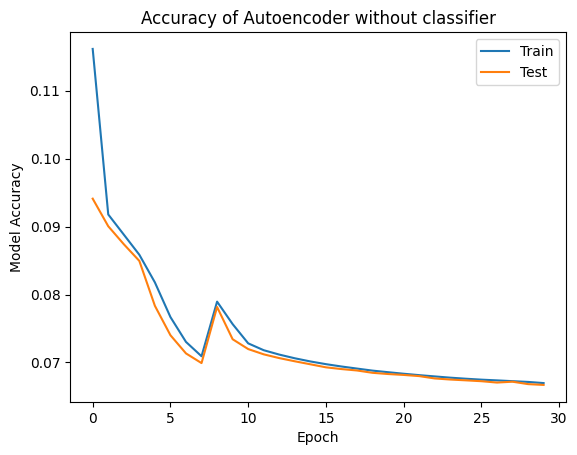

In [15]:
network.plot_score(use_latent_classifier=False, model_name="Autoencoder without classifier")


313/313 [==============================] - 1s 3ms/step


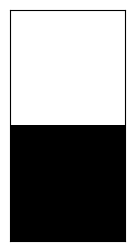

In [16]:
network.plot_latent()


In [ ]:
# network = Autoencoder(data_zoom, pruned=False)
# network.build_encoder()
# network.build_decoder()
# network.build_autoencoder()
network.fit_data(epochs=30)
network.plot_latent_dimension("Autoencoder without classifier")
network.plot_reco(model_name="complete")
network.plot_score(use_latent_classifier=False, model_name="Autoencoder without classifier")
network.plot_latent()


313/313 [==============================] - 1s 3ms/step


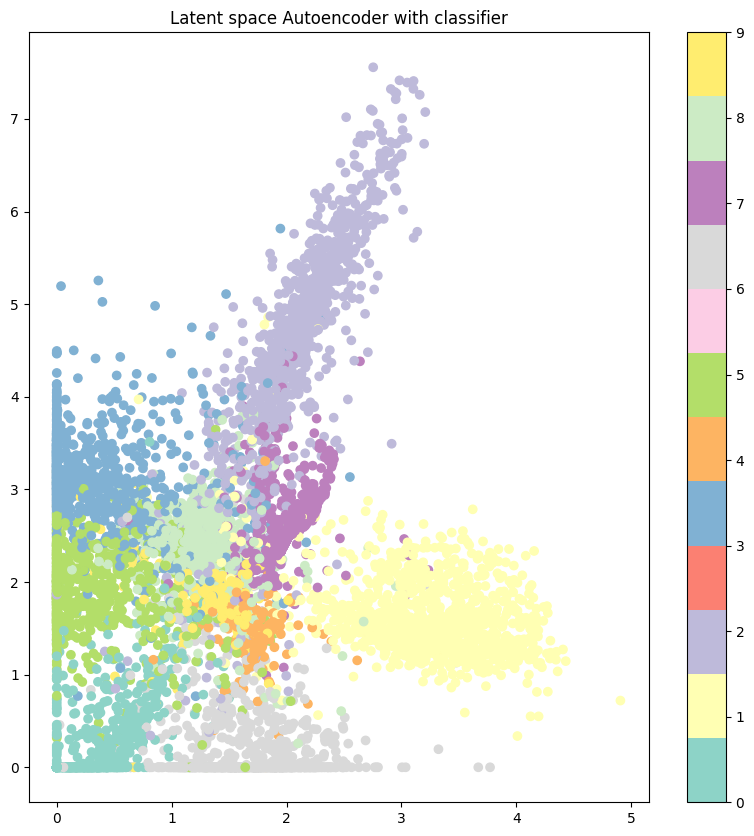

In [18]:
network_with_classifier.plot_latent_dimension("Autoencoder with classifier")


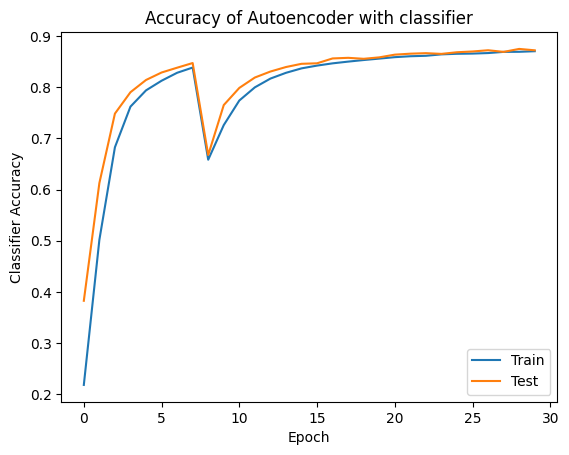

In [19]:
network_with_classifier.plot_score(use_latent_classifier=True,model_name="Autoencoder with classifier")

313/313 [==============================] - 1s 2ms/step


ValueError: cannot reshape array of size 640000 into shape (8,8)

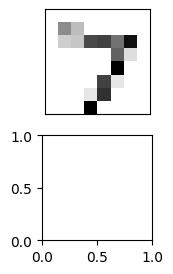

In [17]:
network_with_classifier.plot_reco(model_name="complete")
